<a href="https://colab.research.google.com/github/maltevolle/PMML-Project/blob/animals-10/Project_PMML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from datasets import load_dataset
import random



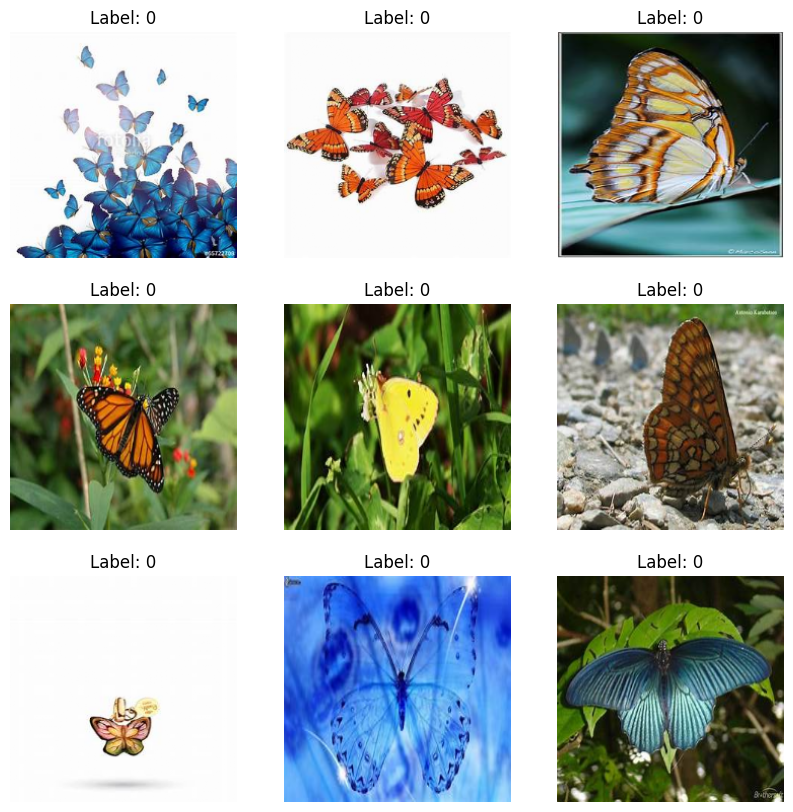

In [ ]:
ds = load_dataset("Rapidata/Animals-10")


# Funktion zum Konvertieren in TensorFlow Dataset
def transform_to_tf(example):
    image = tf.image.resize(example["image"], [224, 224])  # Resize
    image = tf.cast(image, tf.float32) / 255.0  # Normalisierung
    label = tf.convert_to_tensor(example["label"], dtype=tf.int32)
    return image, label


# Umwandlung für Train/Test/Valid-Sets
train_data = tf.data.Dataset.from_generator(
    lambda: (transform_to_tf(ex) for ex in ds["train"]),
    output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_generator(
    lambda: (transform_to_tf(ex) for ex in ds["test"]),
    output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                      tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(32).prefetch(tf.data.AUTOTUNE)



plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):  # Ein Batch nehmen
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
plt.show()




Der Code missklassifiziert die bilder von cats vs dogs mit imagenet. Ich weiß nicht so ganz was der macht aber es funktioniert :)

Verfügbare Splits: dict_keys(['train'])
Trainingsdaten: 18843, Testdaten: 4711
Verarbeitung von Testdaten mit FGSM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Original prediction: ('n01910747', 'jellyfish', 0.11663864)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Adversarial prediction: ('n03729826', 'matchstick', 0.14341906)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Original prediction: ('n03729826', 'matchstick', 0.101630986)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Adversarial prediction: ('n03729826', 'matchstick', 0.12240069)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Original prediction: ('n04286575', 'spotlight', 0.40510458)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Adversarial prediction: ('n03729826', 'matchstick', 0.15548722)
Verarbeitung von Testdaten mit PGD...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Original prediction: ('n04286575', 'spotlight', 0.12270903)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Adversarial prediction: ('n03729826', 'matchstick', 0.10202762)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/ste

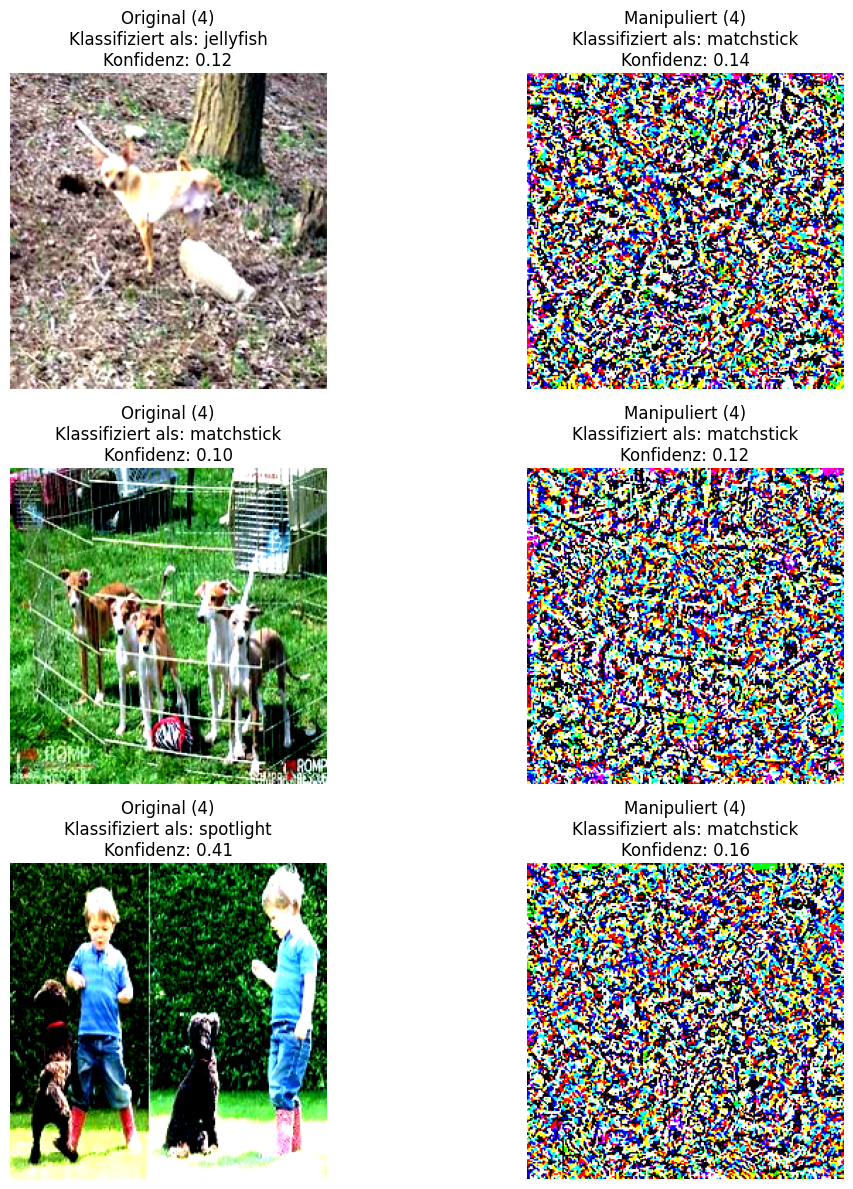

PGD Resultate...


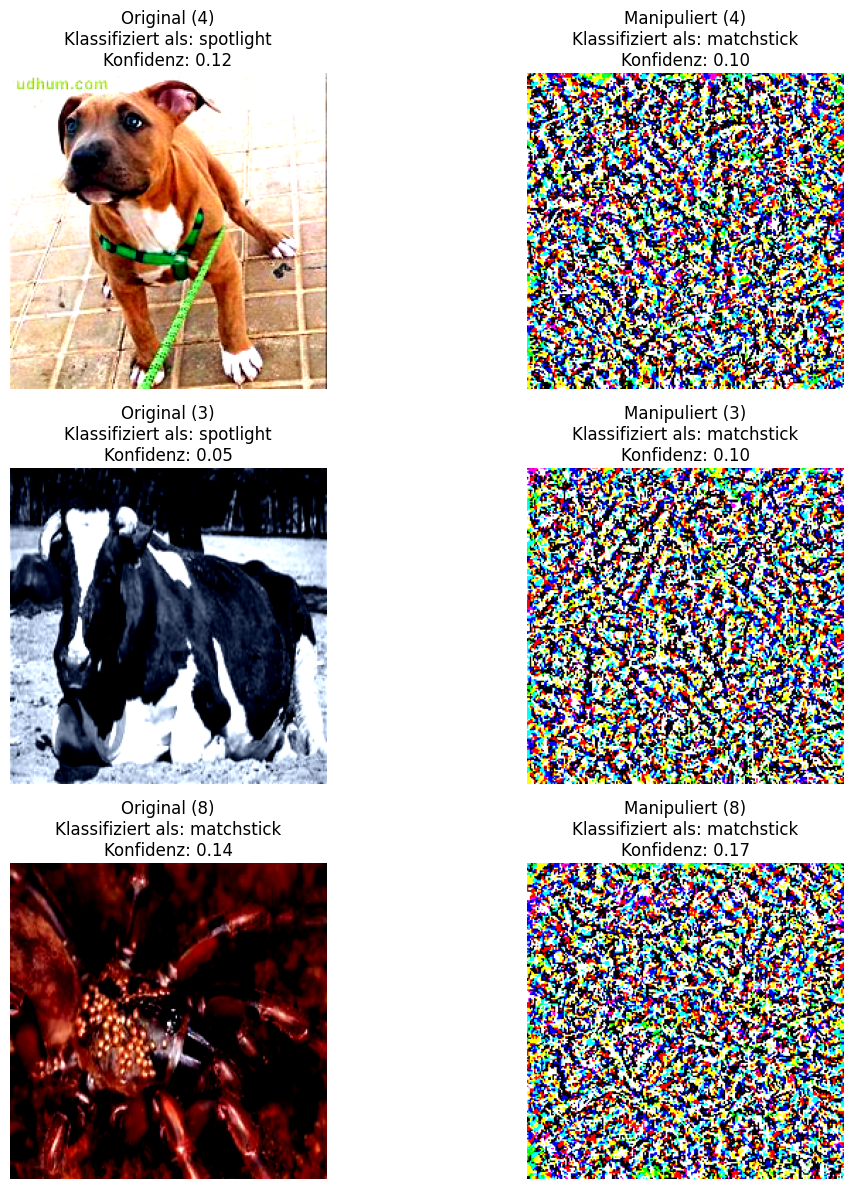

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
import random
from datasets import load_dataset  # Hugging Face Datasets-Bibliothek

# 📌 Laden des vortrainierten Modells (DenseNet121 mit ImageNet-Gewichten)
model = DenseNet121(weights='imagenet')

def load_animals10():
    """Lädt das Animals-10 Dataset von Hugging Face und teilt es in Train/Test auf"""
    dataset = load_dataset("Rapidata/Animals-10")

    # Prüfen, welche Splits existieren
    print("Verfügbare Splits:", dataset.keys())  # Gibt die vorhandenen Splits aus

    # Falls nur 'train' existiert, manuell aufteilen
    full_data = dataset["train"]  # Der gesamte Datensatz
    split_ratio = 0.8  # 80% Training, 20% Test

    # Zufällige Permutation der Daten für eine faire Aufteilung
    shuffled_data = full_data.shuffle(seed=42)
    train_size = int(len(shuffled_data) * split_ratio)

    train_data = shuffled_data.select(range(train_size))
    test_data = shuffled_data.select(range(train_size, len(shuffled_data)))

    print(f"Trainingsdaten: {len(train_data)}, Testdaten: {len(test_data)}")

    return train_data, test_data

def prepare_image(image):
    """Bereitet ein Bild für DenseNet121 vor"""
    image = tf.image.resize(image, (224, 224))  # Größe anpassen
    image = tf.cast(image, tf.float32)  # Zu Float32 konvertieren
    image = preprocess_input(image)  # Vorverarbeitung für DenseNet121
    image = tf.expand_dims(image, 0)  # Batch-Dimension hinzufügen
    return image

# 📌 Mapping von 'Animals-10' auf ImageNet-Klassen
ANIMALS_10_TO_IMAGENET = {
    0: 323,  # Butterfly → Monarch butterfly
    1: 281,  # Cat → Tabby cat
    2: 340,  # Cow → Ox
    3: 243,  # Dog → Golden retriever
    4: 386,  # Elephant → Indian elephant
    5: 339,  # Horse → Arabian horse
    6: 8,    # Chicken → Hen
    7: 359,  # Sheep → Ram
    8: 72,   # Spider → Tarantula
    9: 332   # Squirrel → Grey squirrel
}

def get_imagenet_class(label):
    """Konvertiert Animals-10 Labels zu ImageNet Klassen"""
    return ANIMALS_10_TO_IMAGENET[label]

def create_adversarial_image(image, target_class, epsilon=20.0, iterations=10, method="fgsm"):
    """Erstellt ein adversariales Beispiel"""
    image_tensor = tf.convert_to_tensor(image)
    adv_image = tf.identity(image_tensor)  # Kopie des Originalbilds

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            processed_image = preprocess_input(adv_image)
            prediction = model(processed_image)
            loss = -tf.keras.losses.SparseCategoricalCrossentropy()(
                tf.constant([target_class]), prediction
            )

        # Gradient berechnen
        gradient = tape.gradient(loss, adv_image)
        signed_gradient = tf.sign(gradient)

        if method == "fgsm":
            adv_image = adv_image + epsilon * signed_gradient
            break
        elif method == "pgd":
            adv_image = adv_image + (epsilon / iterations) * signed_gradient
            adv_image = tf.clip_by_value(adv_image, -1, 1)

    adv_image = tf.clip_by_value(adv_image, -1, 1)
    return adv_image

def predict_class(image_array):
    """Klassifiziert ein Bild mit DenseNet121"""
    processed_image = preprocess_input(image_array)
    predictions = model.predict(processed_image)
    decoded_predictions = tf.keras.applications.densenet.decode_predictions(predictions, top=3)[0]
    return decoded_predictions[0]

def process_dataset_samples(dataset, num_samples=3, attack_type="fgsm"):
    """Verarbeitet Beispiele aus dem Dataset"""
    results = []
    selected_samples = random.sample(list(dataset), num_samples)

    for sample in selected_samples:
        image = np.array(sample["image"])  # Bild extrahieren
        label = sample["label"]            # Label extrahieren

        image = prepare_image(image)  # Bild vorbereiten

        # Original klassifizieren
        original_pred = predict_class(image)
        print(f"Original prediction: {original_pred}")

        # Zielklasse setzen (aus dem Mapping)
        target_class = get_imagenet_class(label)

        # Adversariales Beispiel erstellen
        adversarial_img = create_adversarial_image(
            image, target_class, epsilon=20.0, iterations=10 if attack_type == "pgd" else 1, method=attack_type
        )
        adversarial_pred = predict_class(adversarial_img)
        print(f"Adversarial prediction: {adversarial_pred}")

        results.append({
            'original_img': image,
            'adversarial_img': adversarial_img,
            'original_pred': original_pred,
            'adversarial_pred': adversarial_pred,
            'true_class': label
        })

    return results

def denormalize_image(image):
    """Konvertiert ein Bild zurück in den Bereich [0, 255] für Darstellung."""
    image = (image + 1) * 127.5  # Skaliert von [-1,1] auf [0,255]
    image = tf.clip_by_value(image, 0, 255)  # Clipping für sichere Darstellung
    return image.numpy().astype(np.uint8)  # Als Ganzzahl für matplotlib


def plot_results(results):
    """Visualisiert die Ergebnisse"""
    n = len(results)
    fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))

    if n == 1:
        axes = axes.reshape(1, -1)

    for i, result in enumerate(results):
        # Original Bild
        orig_img = denormalize_image(result['original_img'][0])
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f'Original ({result["true_class"]})\n'
                            f'Klassifiziert als: {result["original_pred"][1]}\n'
                            f'Konfidenz: {result["original_pred"][2]:.2f}')

        # Adversariales Bild
        adv_img = denormalize_image(result['adversarial_img'][0])
        axes[i, 1].imshow(adv_img)
        axes[i, 1].set_title(f'Manipuliert ({result["true_class"]})\n'
                            f'Klassifiziert als: {result["adversarial_pred"][1]}\n'
                            f'Konfidenz: {result["adversarial_pred"][2]:.2f}')

        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# 📌 Hauptprogramm
if __name__ == "__main__":
    # Dataset laden
    train_ds, test_ds = load_animals10()

    print("Verarbeitung von Testdaten mit FGSM...")
    fgsm_results = process_dataset_samples(test_ds, num_samples=3, attack_type="fgsm")

    print("Verarbeitung von Testdaten mit PGD...")
    pgd_results = process_dataset_samples(test_ds, num_samples=3, attack_type="pgd")



    print("FGSM Resultate...")
    plot_results(fgsm_results)

    print("PGD Resultate...")
    plot_results(pgd_results)
